In [1]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# import umap
import pandas as pd
from matplotlib import pyplot as plt
from wordcloud import WordCloud
import nltk
# from nltk.corpus import stopwords
import warnings

In [2]:
# nltk.download('stopwords')

In [3]:
def show_wordcloud(df, cluster, artist=None):
    temp = df.loc[df["Cluster"] == cluster]
    if artist is not None:
        temp = temp.loc[temp["Artist"] == artist]
    
    ls = temp["Lyrics"].to_list()
    text = " ".join(ls)

    # text = " ".join([t for t in text.split() if t not in stopwords.words('english')])    
    
    wordcloud = WordCloud().generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [4]:
def numeric_elbow(X, Y):
    best_x = X[0]
    max_diff = 0
    for i, y in enumerate(Y):
        if i == 0:
            continue
        diff = abs(y - Y[i-1])
        if diff > max_diff:
            best_x = X[i]
            max_diff = diff
    return best_x, max_diff

In [5]:
df = pd.read_excel("data/Processed Song Dataset.xlsx")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Artist         1969 non-null   object 
 1   Lyrics         1969 non-null   object 
 2   Song Title     1969 non-null   object 
 3   Year           1969 non-null   int64  
 4   Popularity     1969 non-null   int64  
 5   en_prob        1969 non-null   float64
 6   cleanedLyrics  1969 non-null   object 
dtypes: float64(1), int64(2), object(4)
memory usage: 107.8+ KB


In [6]:
embedder = SentenceTransformer('all-MiniLM-L6-v2')

In [7]:
corpus_embeddings = embedder.encode(df["Lyrics"].to_list())
corpus_embeddings

array([[-0.12999995, -0.0637916 ,  0.06407449, ...,  0.03738614,
        -0.05473032, -0.15832457],
       [-0.14518157, -0.13154864,  0.10331706, ...,  0.0564342 ,
         0.00366876, -0.08716285],
       [-0.1227423 ,  0.02932502,  0.04548375, ...,  0.06399012,
        -0.05790418, -0.09097689],
       ...,
       [-0.0776644 , -0.10381304,  0.01903886, ..., -0.02554433,
         0.05164381, -0.05398848],
       [ 0.00559584, -0.07015812,  0.03215541, ..., -0.00175871,
         0.08286337, -0.09023698],
       [-0.11735578, -0.04859327,  0.07963467, ...,  0.01776394,
        -0.00486743, -0.06499487]], dtype=float32)

In [8]:
pca = PCA()
X_pca = pca.fit_transform(corpus_embeddings)
pca.explained_variance_ratio_[:2]

array([0.08585092, 0.04756894], dtype=float32)

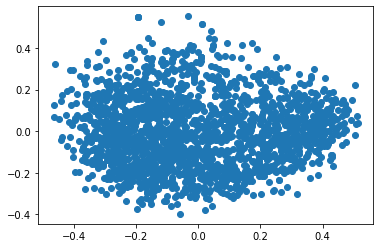

In [9]:
plt.scatter(X_pca[:, 0], X_pca[:, 1]);

In [10]:
sum(pca.explained_variance_ratio_[:50])

0.5937246968969703

In [11]:
min_total_ratio = .70
for i, ratio in enumerate(pca.explained_variance_ratio_):
    min_total_ratio -= ratio
    if min_total_ratio <= 0:
        break
components = i
components


76

In [12]:
best_perplexity = 5
best_divergence = 999
for perplexity in range(5, 50, 5):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        tsne = TSNE(init="pca",
                    perplexity=perplexity,
                    learning_rate="auto",
                    n_iter=5000,
                    n_jobs=4)
        X = tsne.fit_transform(X_pca[:, :components])
    divergence = tsne.kl_divergence_
    print(perplexity, divergence)
    if divergence < best_divergence:
        X_tsne = X
        best_perplexity = perplexity
        best_divergence = divergence

5 2.072441577911377
10 2.208847999572754
15 2.182432174682617
20 2.133463144302368
25 2.0878140926361084
30 2.0448265075683594
35 2.0280847549438477
40 2.011749744415283
45 1.9460668563842773


45 1.9460668563842773


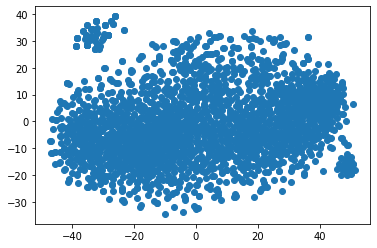

In [13]:
print(best_perplexity, best_divergence)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1]);

In [14]:
tsne.kl_divergence_ #, tsne.feature_names_in_

1.9460668563842773

In [15]:
# Perform kmeans clustering
components = 2
candidates = list(range(2, 10))
scores = [0] * len(candidates)
for i, candidate in enumerate(candidates):
    clustering_model = KMeans(n_clusters=candidate)
    clustering_model.fit(X_pca[:, :components])
    # clustering_model.fit(corpus_embeddings)
    score = clustering_model.inertia_
    scores[i] = score
    print(candidate, score)


2 82.57960510253906
3 54.17184066772461
4 41.6064567565918
5 33.41164779663086
6 28.568012237548828
7 24.55743408203125
8 21.455738067626953
9 18.928194046020508


In [16]:
best_n_clusters, diff = numeric_elbow(candidates, scores)
print("Best Number of Clusters:", best_n_clusters)

Best Number of Clusters: 3


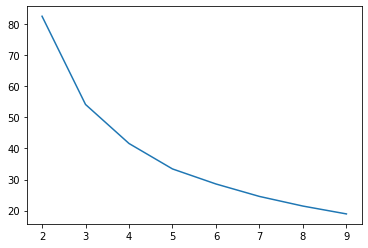

In [17]:
plt.plot(candidates, scores);

In [18]:
clustering_model = KMeans(n_clusters=best_n_clusters, random_state=2022)
clustering_model.fit(X_pca[:, :components])
df["Cluster"] = clustering_model.labels_

In [19]:
df

,Artist,Lyrics,Song Title,Year,Popularity,en_prob,cleanedLyrics,Cluster
0,Santana Featuring Rob Thomas,"Man, it's a hot one Like seven inches from the...",Smooth,2000,0,0.999998,man hot one like seven inch from the midday su...,0
1,Brian McKnight,It's undeniable That we should be together It'...,Back At One,2000,72,0.999997,it undeni that should togeth it unbeliev how u...,0
2,Jessica Simpson,"Ooh, ooh, mmm You set my soul at ease Chased ...",I Wanna Love You Forever,2000,60,0.999996,ooh ooh mmm you set soul eas chase dark out vi...,0
3,Whitney Houston,"Clap your hands, y'all It's alright Turn me up...",My Love Is Your Love,2000,71,0.999993,clap your hand you all it alright turn turn tu...,0
4,Savage Garden,Maybe it's intuition But some things you just ...,I Knew I Loved You,2000,72,0.999996,mayb intuit but some thing you just not questi...,0
...,...,...,...,...,...,...,...,...
1964,Ant Saunders,She put my name with yellow hearts Her favorit...,Yellow Hearts,2020,72,0.999996,she put name with yellow heart her favorit col...,2
1965,Roddy Ricch Featuring A Boogie Wit da Hoodie,"Rose gold Rollie, I'm the nigga put the whole ...",Tip Toe,2020,0,0.999997,rose gold rolli the nigga put the whole damn h...,1
1966,Doja Cat,"I can name a couple ways, baby, this shit migh...",Candy,2020,74,0.999997,can name coupl way babi this shit might you ju...,1
1967,Russ & BIA,"Like the way she work, ayy She always puts me ...",BEST ON EARTH,2020,7,0.999997,like the way she work ayi she alway put first ...,1


In [20]:
df.groupby("Artist").count().sort_values(by="Lyrics", ascending=False).head(5)

,Lyrics,Song Title,Year,Popularity,en_prob,cleanedLyrics,Cluster
Artist,,,,,,,
Taylor Swift,19,19,19,19,19,19,19
Tim McGraw,14,14,14,14,14,14,14
Mariah Carey,14,14,14,14,14,14,14
J. Cole,12,12,12,12,12,12,12
Beyonce,12,12,12,12,12,12,12


In [21]:
df.loc[df["Artist"] == "Mariah Carey"].groupby("Cluster").count()["Song Title"].reset_index()

,Cluster,Song Title
0,0,2
1,1,1
2,2,11


In [22]:
df.loc[(df["Artist"] == "Mariah Carey") & (df["Cluster"] == 0)]

,Artist,Lyrics,Song Title,Year,Popularity,en_prob,cleanedLyrics,Cluster
566,Mariah Carey,"Don't forget about us Don't baby, don't baby, ...",Don't Forget About Us,2006,0,0.999996,dont forget about dont babi not babi not let b...,0
609,Mariah Carey,"Sweet love, yeah I didn't mean it when I said...",We Belong Together,2006,71,0.999997,sweet love yeah did not mean when said did not...,0


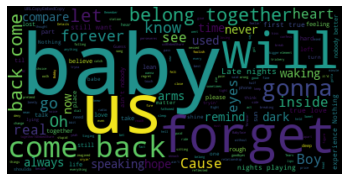

In [23]:
show_wordcloud(df, 0, "Mariah Carey")

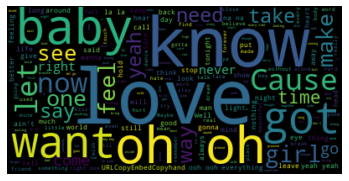

In [24]:
show_wordcloud(df, 0)

In [25]:
df.loc[(df["Artist"] == "Mariah Carey") & (df["Cluster"] == 1)]

,Artist,Lyrics,Song Title,Year,Popularity,en_prob,cleanedLyrics,Cluster
607,Mariah Carey,"Ooh, ooh, ooh, ooh Ooh, ooh, oh Everybody just...",Shake It Off,2006,63,0.999997,ooh ooh ooh ooh ooh ooh everybodi just everybo...,1


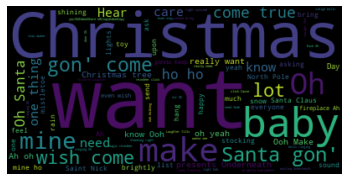

In [26]:
show_wordcloud(df, 2, "Mariah Carey")

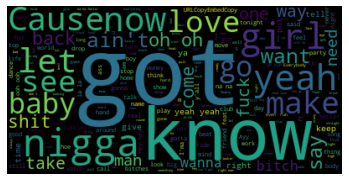

In [27]:
show_wordcloud(df, 1)

In [28]:
df.loc[(df["Artist"] == "Mariah Carey") & (df["Cluster"] == 2)]

,Artist,Lyrics,Song Title,Year,Popularity,en_prob,cleanedLyrics,Cluster
276,Mariah Carey,You're with me Til the bitter end What we have...,Never Too Far/Hero Medley,2002,0,0.999997,your with til the bitter end what have transce...,2
361,Mariah Carey,When you get caught in the rain With nowhere t...,Through The Rain,2003,46,0.999998,when you get caught the rain with nowher run w...,2
1130,Mariah Carey,"Oh, Santa's gon' come and make him mine this C...",Oh Santa!,2011,71,0.999998,santa gon come and make him mine this christma...,2
1246,Mariah Carey,I don't want a lot for Christmas There is just...,All I Want For Christmas Is You,2013,87,0.999997,not want lot for christma there just one thing...,2
1348,Mariah Carey,I don't want a lot for Christmas There is just...,All I Want For Christmas Is You,2014,87,0.999997,not want lot for christma there just one thing...,2
1450,Mariah Carey,I don't want a lot for Christmas There is just...,All I Want For Christmas Is You,2015,87,0.999998,not want lot for christma there just one thing...,2
1528,Mariah Carey,I don't want a lot for Christmas There is just...,All I Want For Christmas Is You,2016,87,0.999997,not want lot for christma there just one thing...,2
1620,Mariah Carey,I don't want a lot for Christmas There is just...,All I Want For Christmas Is You,2017,87,0.999997,not want lot for christma there just one thing...,2
1707,Mariah Carey,I don't want a lot for Christmas There is just...,All I Want For Christmas Is You,2018,87,0.999998,not want lot for christma there just one thing...,2
1791,Mariah Carey,I don't want a lot for Christmas There is just...,All I Want For Christmas Is You,2019,87,0.999995,not want lot for christma there just one thing...,2


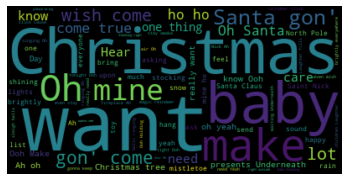

In [29]:
show_wordcloud(df, 2, "Mariah Carey")

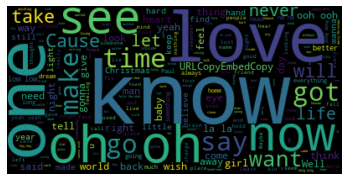

In [30]:
show_wordcloud(df, 2)

Cluster 0


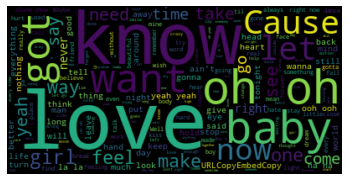

Cluster 1


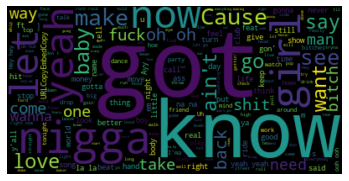

Cluster 2


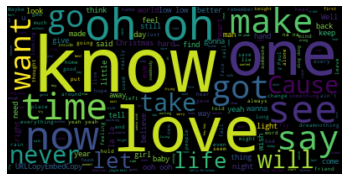

In [31]:
for i in sorted(df.Cluster.drop_duplicates()):
    print("Cluster", i)
    show_wordcloud(df, i)